<a href="https://colab.research.google.com/github/Draganos/PredictiveDataChurn/blob/main/Predictive_Data_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#importing and labelling data
#service represents customer service, activity represents online activity as referred to table above
import pandas as pd
excelfile = pd.ExcelFile("Customer_Churn_Data_Large.xlsx")
excelfile.sheet_names
demographics = pd.read_excel(excelfile, "Customer_Demographics")
transactions = pd.read_excel(excelfile, "Transaction_History")
service = pd.read_excel(excelfile, "Customer_Service")
activity = pd.read_excel(excelfile, "Online_Activity")
churn = pd.read_excel(excelfile, "Churn_Status")

#select only correct columns from demographics dataframe
demographics_selected = demographics[['CustomerID', 'Age', 'Gender', 'IncomeLevel', 'MaritalStatus']]

#merging data under key CustomerID
df = demographics_selected.merge(transactions, on="CustomerID", how="left")
df = df.merge(service, on="CustomerID", how="left")
df = df.merge(activity, on="CustomerID", how="left")
df = df.merge(churn, on="CustomerID", how="left")
df.fillna({
    'IncomeLevel': 'Missing',
}, inplace=True)

# Remove date columns before further processing
df = df.drop(['TransactionDate', 'InteractionDate', 'LastLoginDate'], axis=1)

#remove outliers as needed//set bounds for outliers by quantiles
for col in ['Age', 'AmountSpent', 'LoginFrequency']:
    q01 = df[col].quantile(0.01)
    q99 = df[col].quantile(0.99)
    df[col] = df[col].clip(q01, q99)

df = pd.get_dummies(df, drop_first=True)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric = df.select_dtypes(include=['float64', 'int64']).columns
# Exclude 'ChurnStatus' from scaling
numeric = [col for col in numeric if col != 'ChurnStatus']
df[numeric] = scaler.fit_transform(df[numeric])
df.to_csv("cleaned_churn_dataset.csv", index=False)

##I chose to use Scikit-Learn train-test-split model with the relative test_size, then use the randomForest model as a classifier since it is most suitable with balancing the type of data associated
Note: (relevant to task 2)

Shape of X_train: (5449, 21)
Shape of X_test: (1363, 21)
Shape of y_train: (5449,)
Shape of y_test: (1363,)
Accuracy: 0.9817
Precision: 1.0000
Recall: 0.9008
F1-Score: 0.9478


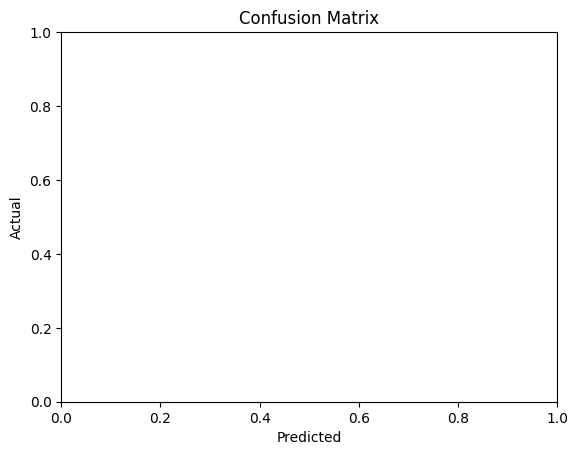

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#drop the 'TransactionDate' column as its not a suitable feature for the model
X = df.drop(['ChurnStatus'], axis=1)
y = df['ChurnStatus']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#test the display the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

#apply the RandomForestClassifier model as needed
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
confusion_matrix = confusion_matrix(y_test, predictions)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]
X_test = X_test.reset_index(drop=True)
X_test['churn_probability'] = probabilities.tolist()

## Analyze churn distribution

### Subtask:
Visualize the distribution of the 'ChurnStatus' column to understand the proportion of churned versus non-churned customers.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='ChurnStatus', data=df)
plt.title('Distribution of Customer Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.show()

numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
exclude_cols = ['CustomerID', 'TransactionID', 'ChurnStatus']
numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=col)
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()